In [2]:
import os 
import numpy as np 
import pandas as pd 
import pickle

import keras
from keras import optimizers, losses, activations, models 
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization 
from sklearn.model_selection import train_test_split

from tensorflow.keras import utils as np_utils #since Tensorflow 2, thats how you import some keras submodules such as keras.utils (it was giving me errors the other way)
import librosa
import matplotlib.pyplot as plt
import librosa.display
import IPython.display

SAMPLE_RATE = 22050
DURATION = 1
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

N_FFT = 1024
HOP_LENGTH = 128
N_MFCC = 15

# Prepare data

In [3]:
def show_mfcc(mfcc):
    librosa.display.specshow(mfcc)
    plt.xlabel("Time")
    plt.ylabel("MFCC")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

In [4]:
#Getting the path to the audio folders

# Change with local
#TestPath ='C:\\_University\\COM3025\\Coursework\\Speech-recognition-COM3025\\data\\raw\\test\\audio\\'
#TrainPath = 'C:\\_University\\COM3025\\Coursework\\Speech-recognition-COM3025\\data\\raw\\train\\audio\\'

#(Alex) the paths above weren't working for me so added my own, feel free to coment them out
TestPath = 'data/test/audio'
TrainPath = 'data/train/audio'


PermitedLabels = ['yes','no','up','down','left','right','on','off','stop','go','silence','unknown']

TestSubPath = [x.name for x in os.scandir(TestPath)] # Get name of subdirectories or files
TrainSubPath = [x.name for x in os.scandir(TrainPath)] # Get name of subdirectories or files

TrainSubPath.remove('_background_noise_')#remove directory of background noises 


In [22]:
len(PermitedLabels)

12

## Analyse data

22050


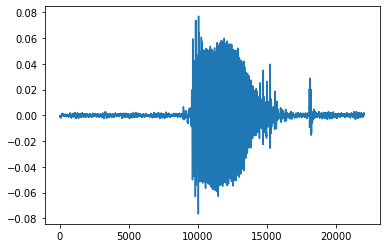

In [10]:
#Example of file load, plot and playback 
audio, sr = librosa.load('data/train/audio/bed/00f0204f_nohash_1.wav')

print(sr)
plt.plot(audio) #Plotting the sound
plt.show()

IPython.display.Audio(audio,rate = sr)#Playing the sound

In [9]:
mel = librosa.feature.melspectrogram(audio, n_fft=N_FFT, hop_length=HOP_LENGTH, sr=SAMPLE_RATE, n_mels=N_MFCC, fmax=8000)
log_mel = librosa.power_to_db(mel, ref=np.max)
librosa.display.specshow(log_mel)
plt.xlabel("Hz")
plt.ylabel("Mel")
plt.colorbar()
# plt.box(False)
plt.show()

NameError: name 'audio' is not defined

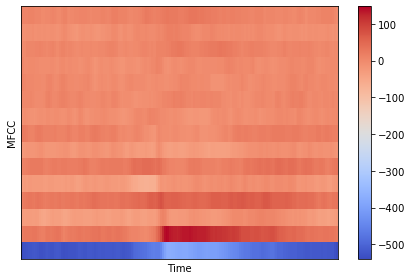

In [7]:
mfcc = librosa.feature.mfcc(audio, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mfcc=N_MFCC)
show_mfcc(mfcc)

## Retrieve data

In [8]:
# One-hot encode the classes
y = list(range(len(PermitedLabels)))
y = np_utils.to_categorical(y)

def one_hot_to_label(one_hot):
    return PermitedLabels[np.argmax(one_hot)]

def label_to_one_hot(label):
    idx = PermitedLabels.index(label)
    return y[idx]


#Helper functions to pad and cut the samples
def pad_audio(signal):
    return np.pad(signal, pad_width = (SAMPLE_RATE - len(signal), 0), mode='constant', constant_values=(0,0))


In [9]:
#Get audio files for training and testing (now only a subset is selected)

# Data object containing MFCC information for each train file
data = {
    'mfccs': [],
    'log-mel': [],
    'classes': []
}

# Process all files in the train set and save their MFCC
for label in TrainSubPath:
    
    # Check if the data will be classified as its label or unknown
    if label in PermitedLabels:  
        # Add label to data
        one_hot = label_to_one_hot(label)
    else:
        one_hot = label_to_one_hot('unknown')
        
    # Retrieve file list
    fullpath = TrainPath + label
    files = [x.name for x in os.scandir(fullpath)]

    for file in files:
        # Load audio
        signal, sr = librosa.load(fullpath + "\\" + file, sr=SAMPLE_RATE)

        # Check lenght of signal and pad if necessary 
        if len(signal) < SAMPLE_RATE:
            signal = pad_audio(signal)

        #Calculate mfcc and log-mel spectrogram
        mfcc = librosa.feature.mfcc(signal, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mfcc=N_MFCC)
        mel = librosa.feature.melspectrogram(signal, n_fft=N_FFT, hop_length=HOP_LENGTH, sr=SAMPLE_RATE, n_mels=N_MFCC, fmax=8000)
        log_mel = librosa.power_to_db(mel, ref=np.max)

        # Capture data
        data['mfccs'].append(mfcc)
        data["log-mel"].append(log_mel)
        data["classes"].append(one_hot)
        
    print(f'loaded: {label}')
    
        

# Save/Load Data

In [12]:
#Changed the data path addapting it to my computer (again change it when needed)

data_path = 'C:\\_University\\COM3025\\Coursework\\Speech-recognition-COM3025\\data\\prepped\\data'
# data_path = 'data/processed/data'

In [11]:
# Save
with open(data_path, 'wb') as f:
    pickle.dump(data, f)

In [21]:
# Load
def load_data():
    data = {}
    with open(data_path, 'rb') as f:
        data = pickle.Unpickler(f).load()
    return data

In [13]:
# Double-check data
print(len(data['mfccs']))
print(len(data['classes']))
print(len(data['log-mel']))

In [14]:
#Check that the shapes of the features extracted are consistent
mfccs = np.array(data['mfccs'])
print(mfccs.shape)
log_mel = np.array(data['log-mel'])
print(log_mel.shape)

the label of this audio file is: up


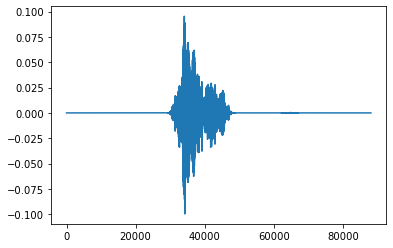

In [20]:
#Checking an audio file to see if it matches its label 
sampleIndex = 58000
audio = librosa.feature.inverse.mfcc_to_audio(data['mfccs'][sampleIndex], n_mels=15)
print("the label of this audio file is: " +  one_hot_to_label(data['classes'][sampleIndex]))

plt.plot(audio) #Plotting the sound
plt.show()

IPython.display.Audio(audio,rate = SAMPLE_RATE) #Playing the sound
